# OPERA RTC-S1 Time-Series: Snow Example

## 1. Import needed Python packages

In [2]:
from getpass import getpass
import opensarlab_lib as osl
from pathlib import Path
from pprint import pprint

from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from osgeo import gdal

import re

import asf_search as disco
from asf_search.download.file_download_type import FileDownloadType

In [3]:
#define a couple functions that will be used later

def timediff(time1,time2,form='days'):
    '''time difference between time2 and time1 expressed as either days or seconds.
    inputs must be in numpy datetime format.'''
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

def dB(arr):
    '''convert power scale image to dB'''
    return 10*np.log10(arr)

## 2. Authenticate with asf_search and start a session

**Gather credentials for authentication with Earth Data Login**

In [4]:
username = input("Enter your EDL username")
password = getpass("Enter your EDL password")

Enter your EDL username acjohnson16
Enter your EDL password ········


**Start an asf_search session**

In [6]:
try:
    user_pass_session = disco.ASFSession().auth_with_creds(username, password)
except disco.ASFAuthenticationError as e:
    print(f'Auth failed: {e}')
else:
    print('Success!')

Success!


## 3. Create a directory in which to download the RTCs

**Create a data directory alongside the Jupyter Book containing this notebook**

We are looking at the Hayes range so I will name it "hayes" here.

In [71]:
name = input("Enter the name of a directory to create, which will hold your downloaded RTCs")
data_dir = Path.cwd().parents[1]/name
data_dir.mkdir(exist_ok=True)
print(f"Data Directory: {data_dir}")

Enter the name of a directory to create, which will hold your downloaded RTCs hayes


Data Directory: /home/jovyan/hayes


## 4. Obtain OPERA products using a Burst ID

The Burst ID is used to identify all images for a specific repeat orbit. The easiest way to identify a burst ID you want to use is using the ASF search webpage: https://search.asf.alaska.edu/#/

For this tutorial we are using the a burst that cover the eastern part of the Hayes Range, including the Black Rapids Glacier. The Burst ID we will use is ```T094_200134_IW2```

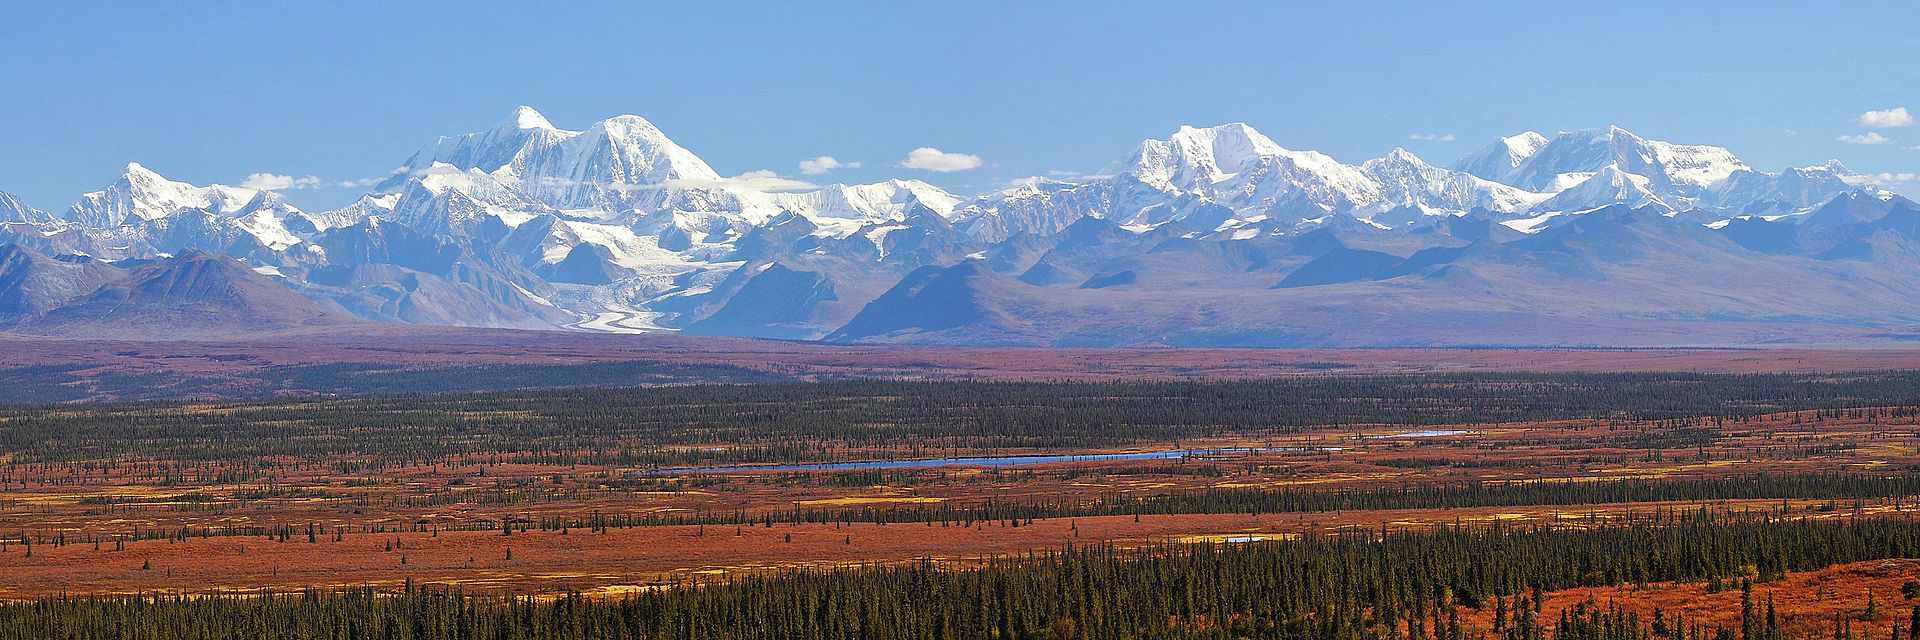 Eastern Hayes Range, as seen from the South. Mount Hayes is the tallest peak in this image (13,832 ft).

We will use the burst information alone to identify and download all images for a given year.

This is not the only way to search and find SAR data to use. See the OPERA Data Access notebooks for information on how to download these tools.

In [151]:
year = 2020
burstID = 'T094_200134_IW2'
# burstID = 'T160_342216_IW2'
# burstID = 'T160_342215_IW2'

options = {
    'dataset': 'OPERA-S1',
    'start': f'{year}-01-01T00:00:00Z',
    'end': f'{year+1}-01-01T00:00:00Z',
    'operaBurstID': burstID,
    'processingLevel': ['RTC'],
    'maxResults': '1000'
}
results = disco.search(**options)
print(f"Found {len(results)} images")

Found 29 images


In [152]:
#Bonus: print out result properties
results[0].properties

{'beamModeType': 'IW',
 'browse': ['https://datapool.asf.alaska.edu/BROWSE/OPERA-S1/OPERA_L2_RTC-S1_T094-200134-IW2_20201221T032017Z_20230928T232124Z_S1B_30_v1.0_BROWSE.png',
  's3://asf-cumulus-prod-opera-browse/OPERA_L2_RTC-S1_CALVAL/OPERA_L2_RTC-S1_T094-200134-IW2_20201221T032017Z_20230928T232124Z_S1B_30_v1.0/OPERA_L2_RTC-S1_T094-200134-IW2_20201221T032017Z_20230928T232124Z_S1B_30_v1.0_BROWSE.png',
  'https://datapool.asf.alaska.edu/BROWSE/OPERA-S1/OPERA_L2_RTC-S1_T094-200134-IW2_20201221T032017Z_20230928T232124Z_S1B_30_v1.0_BROWSE_low-res.png',
  's3://asf-cumulus-prod-opera-browse/OPERA_L2_RTC-S1_CALVAL/OPERA_L2_RTC-S1_T094-200134-IW2_20201221T032017Z_20230928T232124Z_S1B_30_v1.0/OPERA_L2_RTC-S1_T094-200134-IW2_20201221T032017Z_20230928T232124Z_S1B_30_v1.0_BROWSE_low-res.png',
  'https://datapool.asf.alaska.edu/BROWSE/OPERA-S1/OPERA_L2_RTC-S1_T094-200134-IW2_20201221T032017Z_20230928T232124Z_S1B_30_v1.0_BROWSE_thumbnail.png',
  's3://asf-cumulus-prod-opera-browse/OPERA_L2_RTC-S1_C

**Download the RTCs**

Now we will download the data to the ```data_dir``` location

In [153]:
#empty out the existing directory first
for child in data_dir.iterdir():
    child.unlink()

for res in results:
    res.download(data_dir, session=user_pass_session, fileType=FileDownloadType.ALL_FILES)

## 5. Create metadata for accessing the image stack

We create metadata in a pandas dataframe called ```stackmeta``` here. This will contain file names and dates for the SAR images, sorted by date. 

This metadata of file names and dates will be necessary to open up the individual images from the burst stack.

<!-- **Alternative 1: List Search**

- Search by OPERA product ID

- Identify OPERA IDs with an [OPERA-S1 Geographic Search on Vertex](https://search.asf.alaska.edu/#/?maxResults=250&dataset=OPERA-S1) -->

In [157]:
imgname = []
imgfilecp = []  #co-polorized image (VV)
imgfilexp = []  #cross-polarized image (VH)
imgdate = []    #image date in datetime format
imgddoy = []    #image day of year (in decimal days since Jan 1)
yearstart = datetime(year,1,1)

for res in results:
    res = res.properties
    imgname.append(res['sceneName'])
    imgfilecp.append(data_dir/f"{res['sceneName']}_{'VV'}.tif") #co-polarized
    imgfilexp.append(data_dir/f"{res['sceneName']}_{'VH'}.tif") #cross-polarized
    
    rdate = datetime.strptime(res['startTime'],'%Y-%m-%dT%H:%M:%SZ')
    imgdate.append(rdate)
    imgddoy.append(timediff(yearstart,rdate))

stackmeta = pd.DataFrame()
stackmeta['imgname'] = np.array(imgname)
stackmeta['imgfilecp'] = np.array(imgfilecp)
stackmeta['imgfilexp'] = np.array(imgfilexp)
stackmeta['imgdate'] = np.array(imgdate)
stackmeta['imgddoy'] = np.array(imgddoy)
stackmeta = stackmeta.sort_values('imgdate',ignore_index=True)

In [158]:
#Bonus: Explore the dataframe
stackmeta

,imgname,imgfilecp,imgfilexp,imgdate,imgddoy
0,OPERA_L2_RTC-S1_T094-200134-IW2_20200108T03201...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-01-08 03:20:10,7.139005
1,OPERA_L2_RTC-S1_T094-200134-IW2_20200120T03201...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-01-20 03:20:10,19.139005
2,OPERA_L2_RTC-S1_T094-200134-IW2_20200201T03201...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-02-01 03:20:10,31.139005
3,OPERA_L2_RTC-S1_T094-200134-IW2_20200213T03200...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-02-13 03:20:09,43.138993
4,OPERA_L2_RTC-S1_T094-200134-IW2_20200225T03200...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-02-25 03:20:09,55.138993
5,OPERA_L2_RTC-S1_T094-200134-IW2_20200308T03200...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-03-08 03:20:09,67.138993
6,OPERA_L2_RTC-S1_T094-200134-IW2_20200320T03200...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-03-20 03:20:09,79.138993
7,OPERA_L2_RTC-S1_T094-200134-IW2_20200401T03201...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-04-01 03:20:10,91.139005
8,OPERA_L2_RTC-S1_T094-200134-IW2_20200413T03201...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-04-13 03:20:10,103.139005
9,OPERA_L2_RTC-S1_T094-200134-IW2_20200425T03201...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,/home/jovyan/hayes/OPERA_L2_RTC-S1_T094-200134...,2020-04-25 03:20:10,115.139005


## 6. Open the SAR data stack to see the data

Below are several examples of how to open a stack of RTC images

Text(0.5, 1.0, '2020-07-06 03:20:14')

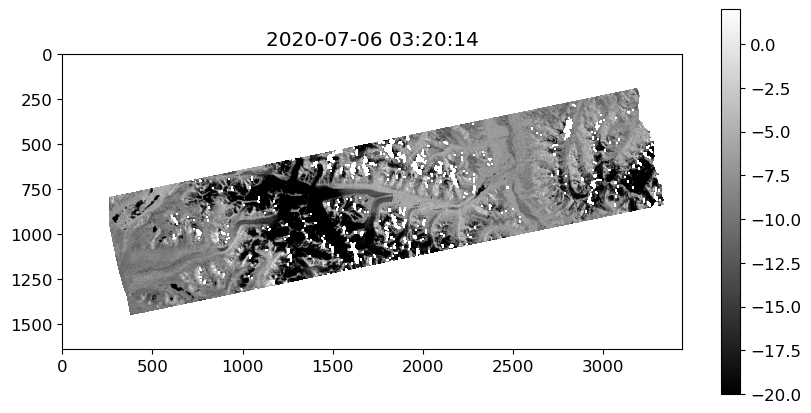

In [161]:
#example of opening a single image by imgind

imgind = 15
imgtype = 'imgfilecp' #use 'imgfilexp' for the VH images instead

singleimage = gdal.Open(str(stackmeta[imgtype][imgind])).ReadAsArray()

plt.figure(figsize=(10,5))
plt.imshow(dB(singleimage),vmin=-20,vmax=2,cmap='gray')
plt.colorbar()
plt.title(stackmeta['imgdate'][imgind])

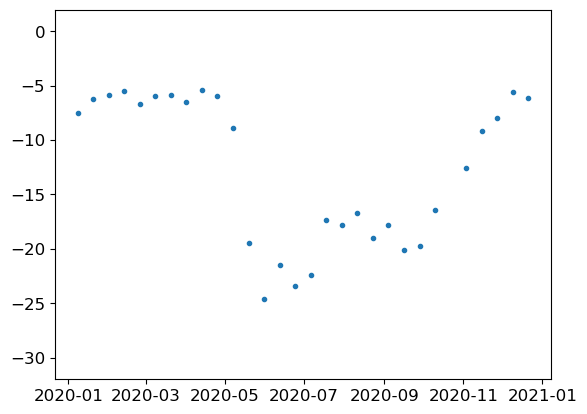

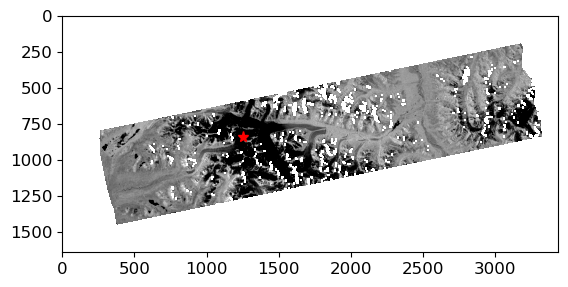

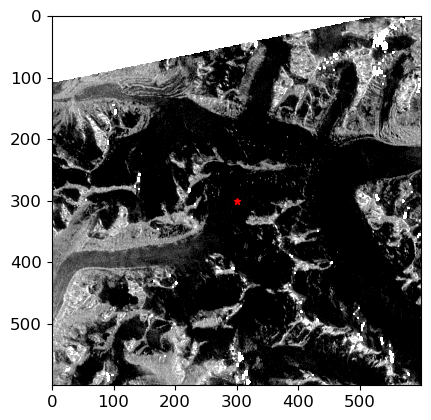

In [162]:
#example of creating a time series of one point

#Points on Black Rapids Glacier
ipt,jpt = 840,1250 #high elevation accumulation area
# ipt,jpt = 800,1400 #part way up Black Rapids Glacier
# ipt,jpt = 840,2030 #Down the Black Rapids Glacier, towards the front

#Other interesting timeseries
# ipt,jpt = 551,2485 #On the Delta River
# ipt,jpt = 1230,480 #Example of vegetation
# ipt,jpt = 1280,625 #On the lake, by the edge
# ipt,jpt = 1290,625 #Middle of the lake

#Or try your own, uncomment the following line and add points:
# ipt,jpt = XX,XX

imgtype = 'imgfilecp' #use 'imgfilexp' for VH

ptvec = []
for i in range(len(stackmeta)):
    cmap = gdal.Open(str(stackmeta[imgtype][i])).ReadAsArray()
    ptvec.append(dB(cmap[ipt,jpt]))


#plot point
plt.figure()
plt.plot(np.array(stackmeta['imgdate']),ptvec,'.')
plt.ylim([-32,2])

#plot where the point is on a map
singleimage = gdal.Open(str(stackmeta['imgfilecp'][15])).ReadAsArray()
plt.figure()
plt.imshow(dB(singleimage),vmin=-20,vmax=2,cmap='gray')
plt.plot(jpt,ipt,'*',color='red',markersize=8)

#plot region in higher resolution
hw = 300 #half window
plt.figure()
plt.imshow(dB(singleimage)[ipt-hw:ipt+hw,jpt-hw:jpt+hw],vmin=-20,vmax=2,cmap='gray')
plt.plot(hw,hw,'*',color='red',markersize=5)

## 7. Load the mask file

We will grab the first mask file we can find, as they will be identical.

OPERA mask files have values of 0, 1, 2, 3, 255 as described by:
- Class 0: Valid sample not affected by layover or shadow
- Class 1: Valid sample affected by shadow
- Class 2: Valid sample affected by layover
- Class 3: Valid sample affected by layover and shadow
- Class 255: Invalid sample (fill value)

For the sake of this workflow, we only need a mask to show where there is data, so we will reduce this to a binary mask.

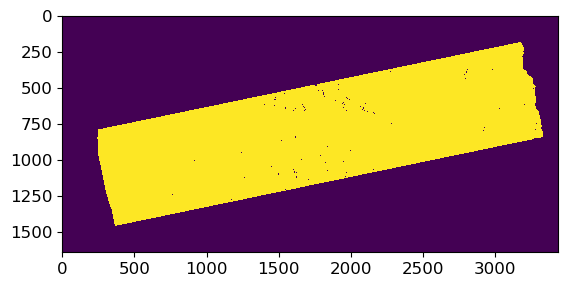

In [165]:
maskfile = data_dir/f"{stackmeta['imgname'][0]}_mask.tif"

mask = gdal.Open(str(maskfile)).ReadAsArray()
mask = mask<=3

plt.figure()
plt.imshow(mask,interpolation='nearest')

## 8. Identify the onset of snow melt

**Determine the melt backscatter threshold**

The onset of snowmelt on non-vegetated terrain can be determined by a tracking when the backscatter drops 3 dB below the mean winter (dry snow) backscatter in C-band (Nagler and Rott, 2000).

To determine this, first we need to calculate the winter mean backscatter for each pixel. We define winter here as Jan. 1 to Apr. 1. We will get the mean of those winter images while only loading one image into memory at a time, rather than the whole stack.

In [166]:
meltthreshold = -3 #dB from winter mean to identify melt at

#identify winter images
winterstart = datetime(year,1,1)
winterend = datetime(year,4,1)

wintermeta = stackmeta.loc[(stackmeta['imgdate']>=winterstart)&(stackmeta['imgdate']<winterend)]
winterimgs = np.array(wintermeta['imgfilecp'])
winterlen = len(wintermeta)
print(f"Found {winterlen} winter images")

#intialize melt threshold map
imgshape = np.shape(mask)
meltth = np.zeros(imgshape)
meltth[~mask]=np.nan

#calculate mean winter backscatter
for i,file in enumerate(winterimgs):
    img = gdal.Open(str(file)).ReadAsArray()
    img = dB(img)
    meltth[mask] += img[mask]
meltth = 1/winterlen * meltth

#Set the melt threshold
meltth = meltth + meltthreshold

Found 7 winter images


Text(0.5, 1.0, 'Melt threshold (dB)')

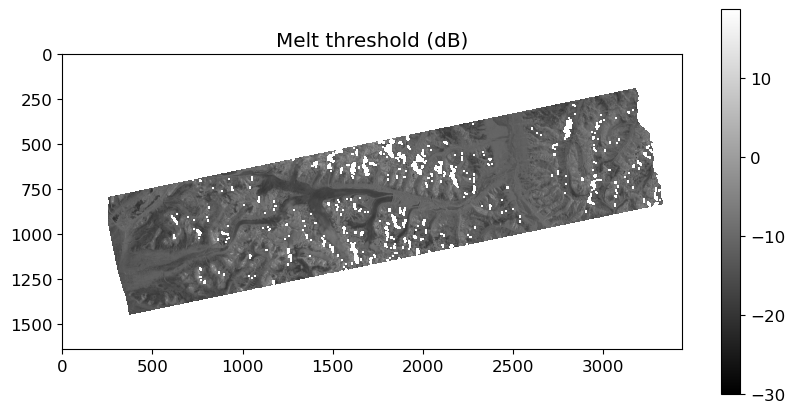

In [167]:
#Plot the threshold
plt.figure(figsize=(10,5))
plt.imshow(meltth,cmap='gray')
plt.colorbar()
plt.title('Melt threshold (dB)')

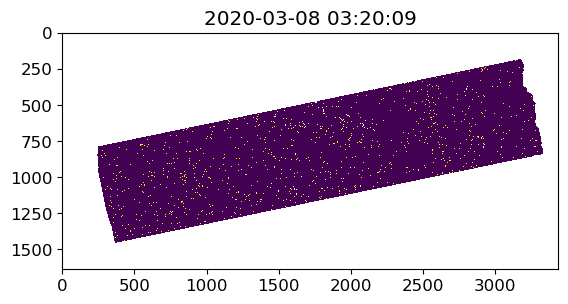

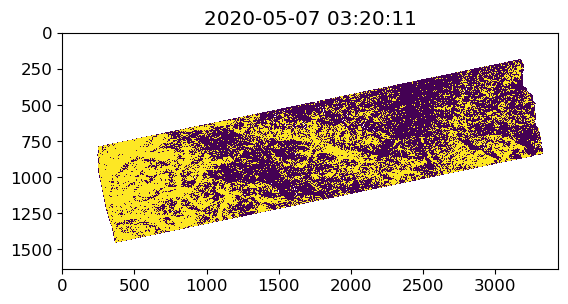

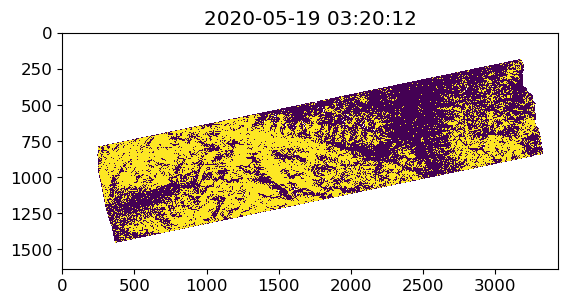

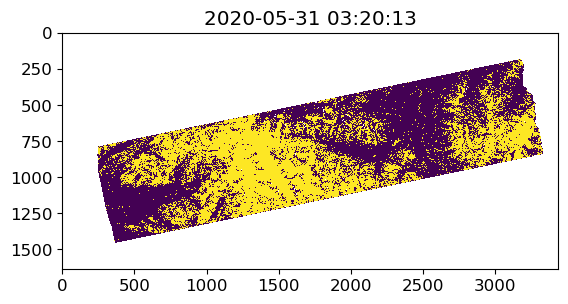

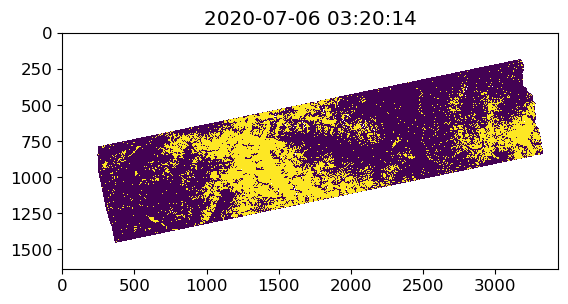

In [168]:
#Plot melt in single images
imgindlist = [5,10,11,12,15]

for imgind in imgindlist:
    singleimage = gdal.Open(str(stackmeta['imgfilecp'][imgind])).ReadAsArray()
    singleimage = dB(singleimage)
    meltmap = np.ma.masked_array(singleimage<meltth,mask=~mask)
    
    plt.figure()
    plt.imshow(meltmap,interpolation='nearest')
    plt.title((stackmeta['imgdate'].iloc[imgind]))

**Identify the date of onset of melt**

To track melt onset, we will identify the first image in which there is melt for each pixel.

The true onset of melt is somewhere between the last image of no melt, and the first image of melt, so we will set the onset date at halfway between those two measurements.

Text(0.5, 1.0, 'Onset of Melt (days since Jan. 1)')

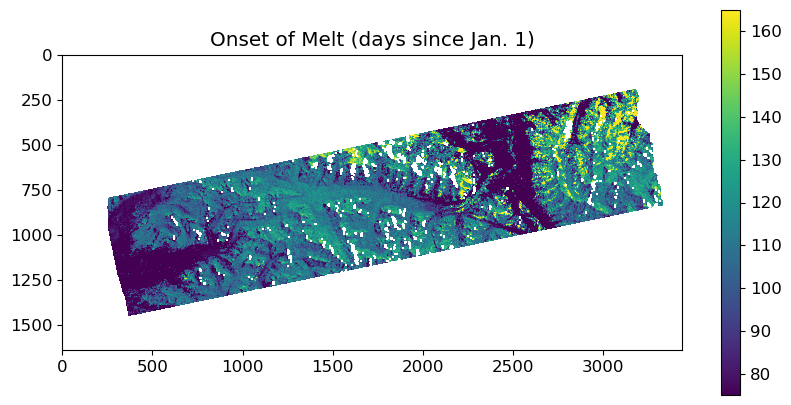

In [143]:
#Map the date of melt onset
meltonsetmap = np.zeros(imgshape)

#create a vector with the day of year (as midpoints between images)
doyvec = stackmeta['imgddoy'][:]
doyvec = np.array(doyvec)
doymid = (doyvec[1:]+doyvec[:-1])*0.5
doymid = np.concatenate(([0],doymid))

#iterate through all image
for i in range(len(stackmeta)):
    cimg = gdal.Open(str(stackmeta['imgfilecp'].iloc[i])).ReadAsArray()
    cmelt = dB(cimg) <= meltth
    updatemask = (cmelt==True) & (meltonsetmap==0)
    meltonsetmap[updatemask] = doymid[i]

meltonsetmap[~mask]=np.nan

#Plot the onset date of melt
plt.figure(figsize=(10,5))
plt.imshow(meltonsetmap,vmin=75,vmax=165)
plt.colorbar()
plt.title('Onset of Melt (days since Jan. 1)')

## 10. Trying several other years and/or burst IDs

Go back to section 4, and try with other possible burst IDs or years.

Similar Burst IDs in the Hayes range:<br>
```T160_342216_IW2``` <br>
```T160_342215_IW2```

Also try other years:```2018```, ```2019```, or ```2021``` for example (2022 has very few images of this region)